In [95]:
import mysql.connector
import pandas as pd
import numpy as np  
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats
import os
import _pickle as cPickle


def save_pvalues(dict):
    pickle_path = 'D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/pvalues.pkl'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as fp:
            pvalue_dict = cPickle.load(fp)
    else:
        pvalue_dict = {}
        
    
    for key in dict.keys():
        pvalue_dict[key] = dict[key]
     
    with open(pickle_path, 'wb') as fp:
        cPickle.dump(pvalue_dict, fp)
        
def test_significance(nomon_data, rowcol_data):
    shapiro_stat, shapiro_p = stats.shapiro(nomon_data - rowcol_data)
    
    if shapiro_p <= 0.05:
        print("Normality Assumption Violated. Running Wilcoxin", shapiro_stat, shapiro_p)

        Z_stat, p_value = stats.wilcoxon(nomon_data-rowcol_data)
        r = Z_stat / (len(nomon_data)*(len(nomon_data)+1)/2)
        return {"Z": Z_stat, "r": r, "p": p_value}
    else:
        print("Running Dependant T test")
        t_stat, p_value = stats.ttest_rel(nomon_data, rowcol_data)
        df = len(nomon_data)-1
        r = np.sqrt(t_stat**2/(t_stat**2+df))
        return {"t": t_stat, "r": r, "p": p_value}
    
def calculate_quantiles(plot_df, metric):
    lower_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.25)
    lower_quantiles = lower_quantiles.reset_index()
    nomon_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "RCS"][metric].values
    
    upper_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.75)
    upper_quantiles = upper_quantiles.reset_index()
    nomon_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "RCS"][metric].values
    
    return {"lower": {"nomon": nomon_lower_quantiles, "rowcol": rowcol_lower_quantiles},
            "upper": {"nomon": nomon_upper_quantiles, "rowcol": rowcol_upper_quantiles}}      
    
    
def r(x, y):
    return x != y


def calc_MSD(a, b):
    
    if a[-1] == "_" or a[-1] == " ":
        a = a[:-1]
    if b[-1] == "_" or b[-1] == " ":
        b = b[:-1]

    a = np.array(list(a))
    b = np.array(list(b))

    D = np.zeros((a.size, b.size))

    for i in range(a.size):
        D[i, 0] = i

    for j in range(b.size):
        D[0, j] = j

    for i in range(a.size):
        for j in range(b.size):
            D[i, j] = min(D[i-1, j]+1, D[i, j-1]+1, D[i-1, j-1] + r(a[i], b[j]))
    return D[-1, -1], D[-1, -1] / b.size

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]
    
scan_delay_li = [2]
for i in range(21):
    scan_delay_li += [2*np.exp((-i)/14)]

extra_delay_li = [2]
for k in range(11):
    extra_delay_li += [0.2*(10-k)]


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="MIuserDB"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_practice, rowcol_practice, nomon_symbol, rowcol_symbol, nomon_text, rowcol_text, dates FROM study_info', con=mydb)

users=[85]
user_df = user_df[user_df["id"].isin(users)].drop_duplicates()
user_df.dates = user_df.dates.apply(lambda x: json.loads(x)[-1])

user_df

,id,nomon_practice,rowcol_practice,nomon_symbol,rowcol_symbol,nomon_text,rowcol_text,dates
13,85,8,2,5,4,3,4,2022-3-15


In [107]:
with open("D:/Users/nickb/PycharmProjectsD/NomonWeb/v1.1.2/resources/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "Click Time STDev (s)", "num_sel", 
                                 "num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov", "Phrase Target", "Final Typed"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}

# Claire Picture Selection
# data_tables = [               
#                ["nomon_session_10_user_85", "nomon", "picture"],
#                ["nomon_session_11_user_85", "nomon", "picture"],
#                ["nomon_session_12_user_85", "nomon", "picture"],]
#                # 
#                # 
#                # ["rowcol_session_3_user_85", "rowcol", "picture"],
#                # ["rowcol_session_4_user_85", "rowcol", "picture"],
#                # ["rowcol_session_5_user_85", "rowcol", "picture"],]

data_tables = [
    ["nomon_session_1_user_85", "nomon", "picture"],
               ["nomon_session_2_user_85", "nomon", "picture"],
               ["nomon_session_3_user_85", "nomon", "picture"],
               ["nomon_session_4_user_85", "nomon", "picture"],
               ["nomon_session_5_user_85", "nomon", "picture"],
               ["nomon_session_6_user_85", "nomon", "picture"],
               ["nomon_session_7_user_85", "nomon", "picture"],
               ["nomon_session_8_user_85", "nomon", "picture"],
               ["nomon_session_9_user_85", "nomon", "picture"],

               ["nomon_session_10_user_85", "nomon", "picture"],
               ["nomon_session_11_user_85", "nomon", "picture"],
               ["nomon_session_12_user_85", "nomon", "picture"],
                ["nomon_session_15_user_85", "nomon", "text"],
               ["nomon_session_16_user_85", "nomon", "text"],
               
               ["rowcol_session_1_user_85", "rowcol", "picture"],

               ["rowcol_session_3_user_85", "rowcol", "picture"],
               ["rowcol_session_4_user_85", "rowcol", "picture"],
               ["rowcol_session_5_user_85", "rowcol", "picture"],
                

               ["rowcol_session_7_user_85", "rowcol", "text"],
               ["rowcol_session_8_user_85", "rowcol", "text"],
               ["rowcol_session_9_user_85", "rowcol", "text"],
               ["rowcol_session_10_user_85", "rowcol", "text"],]

# Claire Text Entry
# data_tables = [
#     ["nomon_session_15_user_85", "nomon", "text"],
#                ["nomon_session_16_user_85", "nomon", "text"],
# 
#                ["rowcol_session_7_user_85", "rowcol", "text"],
#                ["rowcol_session_8_user_85", "rowcol", "text"],
#                ["rowcol_session_9_user_85", "rowcol", "text"],
#                ["rowcol_session_10_user_85", "rowcol", "text"],]

# Darren Text Entry
# data_tables = [["nomon_session_2_user_7", "nomon"],
#                ["nomon_session_3_user_7", "nomon"],
#                ["nomon_session_6_user_7", "nomon"],
#                ["nomon_session_7_user_7", "nomon"],
#                ["nomon_session_8_user_7", "nomon"],
#                ["nomon_session_9_user_7", "nomon"],
#                ["nomon_session_21_user_7", "nomon"],
#                ["nomon_session_22_user_7", "nomon"],
#                ["nomon_session_23_user_7", "nomon"],
#                ["nomon_session_26_user_7", "nomon"],
#                ["nomon_session_27_user_7", "nomon"],
#                ["nomon_session_28_user_7", "nomon"],
#                ["nomon_session_29_user_7", "nomon"],
#                ["nomon_session_30_user_7", "nomon"],
#                ["nomon_session_31_user_7", "nomon"],
#                
#                ["rowcol_session_1_user_7", "rowcol"],
#                ["rowcol_session_2_user_7", "rowcol"],
#                ["rowcol_session_3_user_7", "rowcol"],
#                ["rowcol_session_4_user_7", "rowcol"],
#                ["rowcol_session_5_user_7", "rowcol"],
#                ["rowcol_session_6_user_7", "rowcol"],
#                ["rowcol_session_7_user_7", "rowcol"],
#                ["rowcol_session_8_user_7", "rowcol"],
#                ["rowcol_session_9_user_7", "rowcol"],
#                ["rowcol_session_10_user_7", "rowcol"],
#                ["rowcol_session_11_user_7", "rowcol"],
#                ["rowcol_session_12_user_7", "rowcol"],
#                ["rowcol_session_13_user_7", "rowcol"],
#                ["rowcol_session_14_user_7", "rowcol"],
#                ["rowcol_session_15_user_7", "rowcol"],]

user=85
nomon_session_num = 0
rowcol_session_num = 0
for data_table, software, style in data_tables:
    if software == "nomon":
        nomon_session_num+=1
        session_num=nomon_session_num
    elif software == "rowcol":
        rowcol_session_num+=1
        session_num=rowcol_session_num
    
    mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
    phrase_nums = np.array(mycursor.fetchall()).T[0]
    for phrase_num in phrase_nums:
        trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
        
        mycursor.execute("SELECT abs_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp ASC")
        
        click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
        while len(click_times[0]) == 0:
            click_times = click_times[1:]
        first_press = click_times[0][0]
        num_clicks = sum([len(click_arr) for click_arr in click_times])
        
        
        # mycursor.execute("SELECT rel_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
        #                  " ORDER BY timestamp ASC")
        
        # click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
        # flattened_click_times = [time for selection in click_times for time in selection]
        # click_time_std = np.std(flattened_click_times)

        
        # if (software == "rowcol"):
        #     num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
        # else:
        num_mispress = 0
        
        mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp DESC LIMIT 1")
        last_selection = mycursor.fetchall()[0][0]
    
    
        mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp DESC LIMIT 1")
        typed_text = mycursor.fetchall()[0][0]
        # if typed_text[-2:] != "..":
        #     continue
        # if software == "nomon":
        #     typed_text = typed_text.replace(".", "")
        #     typed_text = typed_text.replace("_", "")
        # else:       
        #     typed_text = typed_text.replace(".._", "")
        #     typed_text = typed_text.replace("..", "")
        
        mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
        phrase_text = mycursor.fetchall()[0][0]
        
        
        
        if style == "picture":
            
            typed_text = typed_text.replace("..", "")
            
            typed_text_arr=typed_text.split(" ")[:-1]
            typed_len = len(typed_text_arr)
            if typed_len < 3:
                continue
            elif typed_len < 5:
                phrase_text_arr=phrase_text.split(" ")[:typed_len]
            else:
                phrase_text_arr=phrase_text.split(" ")[:-1]
            
            uncorrected_error = calc_MSD(typed_text_arr, phrase_text_arr)[1]
            is_oov = False
            
        else:
            if software == "nomon":
                typed_text = typed_text.replace(".", "")
                typed_text = typed_text.replace("_", "")
            else:
                typed_text = typed_text.replace(".._", "")
                typed_text = typed_text.replace("..", "")
        
            typed_len = len(typed_text)
            if typed_len < 10:
                continue
            
            uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
            is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
        
        if typed_len == 0:
            continue
        
        
        mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
        num_selections = mycursor.fetchall()[0][0]
        
        mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " AND (selection = '@' OR selection = '#' OR selection = 'undefined')")
        num_corrections = mycursor.fetchall()[0][0]
        
        if software == "nomon":
            mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                             " ORDER BY timestamp DESC LIMIT 1")
            rotate_ind = mycursor.fetchall()[0][0]
            trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
        else:
            mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                             " ORDER BY timestamp DESC LIMIT 1")
            scan_delay, extra_delay = mycursor.fetchall()[0]
            trial_data["Scan Delay"] = scan_delay_li[scan_delay]
            trial_data["Extra Delay"] = extra_delay_li[extra_delay]
        
        
        trial_data["typed_len"] = typed_len
        trial_data["start"] = first_press
        trial_data["end"] = last_selection
        trial_data["num_click"] = num_clicks
        trial_data["num_sel"] = num_selections
        trial_data["num_corr"] = num_corrections + num_mispress
        trial_data["Final Error Rate"] = uncorrected_error
        trial_data["is_oov"] = is_oov
        trial_data["Phrase Target"] = phrase_text
        trial_data["Final Typed"] = typed_text
        # trial_data["Click Time STDev (s)"] = click_time_std
        
        entry_df = entry_df.append(trial_data, ignore_index=True)
                

entry_df["Entry Rate (wpm)"] = entry_df.typed_len / (entry_df.end - entry_df.start) / 5 * 60
entry_df["Entry Rate (selections/min)"] = entry_df.typed_len / (entry_df.end - entry_df.start) * 60
entry_df["Click Load (clicks/char)"] = entry_df.num_click / entry_df.typed_len
entry_df["Correction Rate"] = entry_df.num_corr / entry_df.num_sel

entry_df["id"] = pd.to_numeric(entry_df["id"])
entry_df["Session Number"] = pd.to_numeric(entry_df["Session Number"])
entry_df["Phrase Number"] = pd.to_numeric(entry_df["phrase_num"])
entry_df["Entry Rate (wpm)"] = pd.to_numeric(entry_df["Entry Rate (wpm)"])
entry_df["Entry Rate (selections/min)"] = pd.to_numeric(entry_df["Entry Rate (selections/min)"])
entry_df["Click Load (clicks/char)"] = pd.to_numeric(entry_df["Click Load (clicks/char)"])
entry_df["Click Load (clicks/selection)"] = pd.to_numeric(entry_df["Click Load (clicks/char)"])
entry_df["Correction Rate"] = pd.to_numeric(entry_df["Correction Rate"])
entry_df["Final Error Rate"] = pd.to_numeric(entry_df["Final Error Rate"])
entry_df["Uncorrected Error"] = entry_df["Final Error Rate"] > 0
entry_df["Time Rotate"] = pd.to_numeric(entry_df["Time Rotate"])

cmap = matplotlib.cm.get_cmap('cool')
entry_df["color"]= [cmap(i/12) for i in entry_df["Session Number"].to_numpy()]

# entry_df = entry_df[(entry_df["Final Error Rate"] < .2)]

# entry_df = entry_df.set_index(['Session Number', 'Phrase Number'])
entry_df = entry_df.reset_index()

entry_df.head(10)
# 
# grouped_df_mi = entry_df.groupby(['id', 'Session Number', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
#                                                 'Entry Rate (selections/min)': ['mean'],
#                                                 "Click Load (clicks/char)": ['mean'],
#                                                 "Click Load (clicks/selection)": ['mean'],
#                                                 "Correction Rate": ['mean'],
#                                                 "Final Error Rate": ['mean'],
#                                                 "Time Rotate": ['mean'],
#                                                 "Scan Delay": ['mean'],
#                                                 "Extra Delay": ['mean']})
# grouped_df_mi.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)','Click Load (clicks/selection)', 'Correction Rate',
#                     'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
# grouped_df_mi = grouped_df_mi.reset_index()



,index,id,Session Number,Keyboard,phrase_num,typed_len,num_click,Click Time STDev (s),num_sel,num_corr,...,Phrase Target,Final Typed,Entry Rate (wpm),Entry Rate (selections/min),Click Load (clicks/char),Correction Rate,Phrase Number,Click Load (clicks/selection),Uncorrected Error,color
0,0,85,1,Nomon,1,5,20,NaN,7,0,...,break go big where bumpy,break go big where bumpy,0.798286,3.991432,4.000000,0.0,1,4.000000,False,"(0.08235294117647059, 0.9176470588235294, 1.0,..."
1,1,85,1,Nomon,2,5,22,NaN,7,0,...,with now what scared break,with now what see break,0.800331,4.001654,4.400000,0.0,2,4.400000,True,"(0.08235294117647059, 0.9176470588235294, 1.0,..."
2,2,85,1,Nomon,3,5,29,NaN,7,0,...,bad work do excited who,bad work do excited hard,0.611733,3.058665,5.800000,0.0,3,5.800000,True,"(0.08235294117647059, 0.9176470588235294, 1.0,..."
3,3,85,1,Nomon,4,6,44,NaN,9,0,...,mine read here work turn,mine on here work something_different .excited,0.449231,2.246153,7.333333,0.0,4,7.333333,True,"(0.08235294117647059, 0.9176470588235294, 1.0,..."
4,4,85,2,Nomon,1,5,40,NaN,7,0,...,make again bumpy i what,away again bumpy i what,0.460112,2.300561,8.000000,0.0,1,8.000000,True,"(0.16470588235294117, 0.8352941176470589, 1.0,..."
5,5,85,2,Nomon,2,5,22,NaN,7,0,...,now what read this is,now what read this is,0.914481,4.572404,4.400000,0.0,2,4.400000,False,"(0.16470588235294117, 0.8352941176470589, 1.0,..."
6,6,85,2,Nomon,3,6,63,NaN,9,0,...,is bumpy sick sad play,is put sick sad big .i,0.425260,2.126302,10.500000,0.0,3,10.500000,True,"(0.16470588235294117, 0.8352941176470589, 1.0,..."
7,7,85,2,Nomon,4,6,51,NaN,8,0,...,play happy all_gone hard this,play happy all_gone hard this in,0.566002,2.830011,8.500000,0.0,4,8.500000,True,"(0.16470588235294117, 0.8352941176470589, 1.0,..."
8,8,85,2,Nomon,5,4,30,NaN,4,0,...,on don8t mad scared excited,on don8t mad scared,0.727581,3.637907,7.500000,0.0,5,7.500000,False,"(0.16470588235294117, 0.8352941176470589, 1.0,..."
9,9,85,3,Nomon,1,5,28,NaN,7,0,...,where put sad bumpy me,where put sad bumpy here,0.820726,4.103630,5.600000,0.0,1,5.600000,True,"(0.25098039215686274, 0.7490196078431373, 1.0,..."


In [68]:

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDBnew"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_sessions, rowcol_sessions, dates FROM study_info', con=mydb)

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]
users=[98, 133, 140, 161, 168, 175, 182, 196, 231, 238, 245, 252, 259]

user_df = user_df[user_df["id"].isin(users)].drop_duplicates()
user_df.dates = user_df.dates.apply(lambda x: json.loads(x)[-1])

user_df

with open("D:/Users/nickb/PycharmProjectsD/NomonWeb/v1.1.2/resources/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df_ab = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "num_sel", 
                                 "num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}
for user in users:
    print(user)
    for software in software_names.keys():
        software_sessions = user_df[(user_df.id == user)][software+"_sessions"].values[0]
        for session_num in range(1, software_sessions+1):
            data_table = software + "_session_"+str(session_num)+"_user_"+str(user)
            
            mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
            phrase_nums = np.array(mycursor.fetchall()).T[0]
            for phrase_num in phrase_nums:
                trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
                
                mycursor.execute("SELECT abs_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp ASC")
                click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
                while len(click_times[0]) == 0:
                    click_times = click_times[1:]
                first_press = click_times[0][0]
                num_clicks = sum([len(click_arr) for click_arr in click_times])
                # if (software == "rowcol"):
                #     num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
                # else:
                num_mispress = 0
                
                mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                last_selection = mycursor.fetchall()[0][0]

                mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                typed_text = mycursor.fetchall()[0][0]
                typed_len = len(typed_text)
                if session_num == 10:
                    typed_len /= 2
                
                mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
                phrase_text = mycursor.fetchall()[0][0]

                uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
                
                is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
                num_selections = mycursor.fetchall()[0][0]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " AND (selection = '@' OR selection = '#' OR selection = 'undefined')")
                num_corrections = mycursor.fetchall()[0][0]
                
                if software == "nomon":
                    mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    rotate_ind = mycursor.fetchall()[0][0]
                    trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
                else:
                    mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    scan_delay, extra_delay = mycursor.fetchall()[0]
                    trial_data["Scan Delay"] = scan_delay_li[scan_delay]
                    trial_data["Extra Delay"] = extra_delay_li[extra_delay]
                
                
                trial_data["typed_len"] = typed_len
                trial_data["start"] = first_press
                trial_data["end"] = last_selection
                trial_data["num_click"] = num_clicks
                trial_data["num_sel"] = num_selections
                trial_data["num_corr"] = num_corrections + num_mispress
                trial_data["Final Error Rate"] = uncorrected_error
                trial_data["is_oov"] = is_oov
                
                
                entry_df_ab = entry_df_ab.append(trial_data, ignore_index=True)
                

entry_df_ab["Entry Rate (wpm)"] = entry_df_ab.typed_len / (entry_df_ab.end - entry_df_ab.start) / 5 * 60
entry_df_ab["Entry Rate (selections/min)"] = entry_df_ab.typed_len / (entry_df_ab.end - entry_df_ab.start) * 60
entry_df_ab["Click Load (clicks/char)"] = entry_df_ab.num_click / entry_df_ab.typed_len
entry_df_ab["Correction Rate"] = entry_df_ab.num_corr / entry_df_ab.num_sel

entry_df_ab["id"] = pd.to_numeric(entry_df_ab["id"])
entry_df_ab["Session Number"] = pd.to_numeric(entry_df_ab["Session Number"])
entry_df_ab["Entry Rate (wpm)"] = pd.to_numeric(entry_df_ab["Entry Rate (wpm)"])
entry_df_ab["Entry Rate (selections/min)"] = pd.to_numeric(entry_df_ab["Entry Rate (selections/min)"])
entry_df_ab["Click Load (clicks/char)"] = pd.to_numeric(entry_df_ab["Click Load (clicks/char)"])
entry_df_ab["Correction Rate"] = pd.to_numeric(entry_df_ab["Correction Rate"])
entry_df_ab["Final Error Rate"] = pd.to_numeric(entry_df_ab["Final Error Rate"])
entry_df_ab["Time Rotate"] = pd.to_numeric(entry_df_ab["Time Rotate"])

grouped_df_ab = entry_df_ab.groupby(['id', 'Session Number', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
grouped_df_ab.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
grouped_df_ab = grouped_df_ab.reset_index()




98
133
140
161
168
175
182
196
231
238
245
252
259


In [ ]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)

sns.stripplot(x="id", y="Entry Rate (wpm)", hue="Keyboard",
              data=grouped_df_ab, dodge=True, alpha=.25, zorder=1, ax=ax)

sns.pointplot(x="id", y="Entry Rate (wpm)", hue="Keyboard",
              data=entry_df, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None, ax=ax)


In [10]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = grouped_df_ab[(grouped_df_ab["Session Number"] > 1) & (grouped_df_ab["Session Number"] <= 9)]
plot_df["Session Number"] = plot_df["Session Number"]-2
plot_df=plot_df[(plot_df["Keyboard"] == "Nomon")]
plot_df["Practice Time (min)"] = plot_df["Session Number"]*20

grouped_df_mi = grouped_df_mi[grouped_df_mi["Keyboard"] == "Nomon"]
grouped_df_mi["Practice Time (min)"] = (grouped_df_mi["Session Number"]-1)*14

metrics= ['Entry Rate (wpm)', "Click Load (clicks/char)"]
a4_dims = (12, 4)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Practice Time (min)", y=metric, hue="Keyboard", style="Keyboard", estimator=np.median,
                  data=grouped_df_mi, ax=ax, ci=None, linewidth=3)
    
    sns.lineplot(x="Practice Time (min)", y=metric, hue="Keyboard", palette=['darkorange'], linestyle="--", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=4)
    
    
        
    if ax_ind == 0:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        lines = leg.get_lines()
        for line in lines:
            line.set_linewidth(4)
        lines[1].set_linestyle("--")
        leg.get_texts()[0].set_text('Switch User')
        leg.get_texts()[1].set_text('AB Users')
        leg.set_title("")


    quantiles = calculate_quantiles(entry_df, metric)
    ax.fill_between(np.arange(0, 15)*14, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
    
    quantiles = calculate_quantiles(plot_df, metric)
    # 
    ax.fill_between(np.arange(0, 8)*20, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='orange', alpha = 0.2, interpolate=True)
    
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/mi_longform.png", dpi=300)
plt.show()

NameError: name 'grouped_df_ab' is not defined

<Figure size 432x288 with 0 Axes>

ValueError: operands could not be broadcast together with shapes (12,) (3,) 

<Figure size 432x288 with 0 Axes>

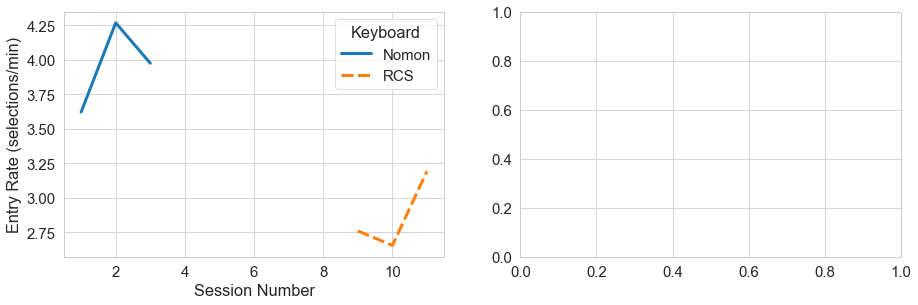

In [11]:

sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = grouped_df_mi[(grouped_df_mi["Session Number"] >= 1) ]
plot_df.loc[plot_df["Keyboard"] == "RCS", ["Session Number"]] = plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"] + 8

metrics = ['Entry Rate (selections/min)', "Click Load (clicks/selection)"]
a4_dims = (15, 5)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Session Number", y=metric, hue="Keyboard", style="Keyboard", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=3)
    
    quantiles = calculate_quantiles(entry_df, metric)
        
    if ax_ind == 1:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        for line in leg.get_lines():
            line.set_linewidth(3)

    # 
    ax.fill_between(range(1, 13), quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)

    ax.fill_between(range(9, 13), quantiles["lower"]["rowcol"], quantiles["upper"]["rowcol"],
                    where=quantiles["upper"]["rowcol"] >= quantiles["lower"]["rowcol"], facecolor='orange', alpha = 0.2, interpolate=True)
    ax.axvline(10, color="k")

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_picture_selection_longform.pdf")
plt.show()

[]

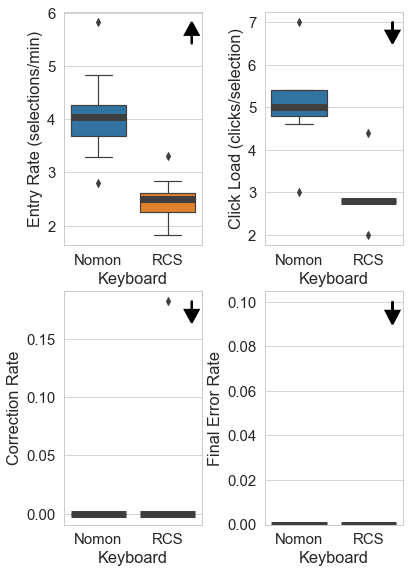

In [31]:

sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
# plt.tight_layout()
sns.set_palette("tab10")

plot_df = entry_df[(entry_df["Session Number"] >= 1) ]

entry_stats = ["Entry Rate (selections/min)", "Click Load (clicks/selection)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(2, 2,figsize=(6,8))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.15)
axes = list(axes)
# fig.suptitle('Entry Statistics for Sessions 7-9')

indicies = [(0,0), (0,1), (1, 0), (1,1)][::-1]
for entry_stat in entry_stats:
    ind = indicies.pop()
    cur_ax = axes[ind[0]][ind[1]]
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=plot_df, ax=cur_ax)
    if entry_stat == "Entry Rate (selections/min)":
        y_max = np.max(plot_df[entry_stat])
        y_min = np.min(plot_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    elif entry_stat == "Final Error Rate":
        y_max = np.max(0.1)
        y_min = np.min(0)
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
        cur_ax.set_ylim(y_min, 0.105)
    else:
        y_max = np.max(plot_df[entry_stat])
        y_min = np.min(plot_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1

        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
        
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_picture_boxplot.svg")

plt.plot()
    

<Figure size 432x288 with 0 Axes>

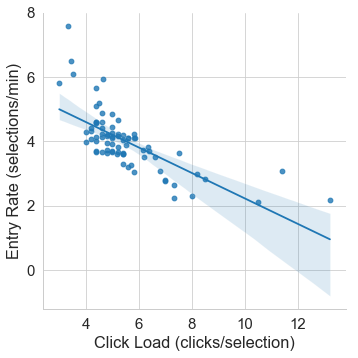

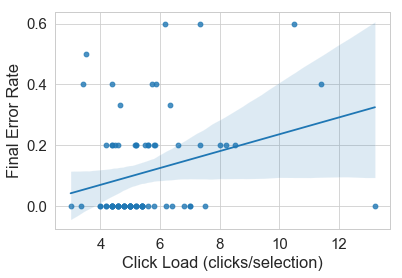

In [34]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

sns.lmplot(data=entry_df, x="Click Load (clicks/selection)", y="Entry Rate (selections/min)")
plt.show()

sns.regplot(data=entry_df, x="Click Load (clicks/selection)", y="Final Error Rate")
plt.show()


<Figure size 432x288 with 0 Axes>

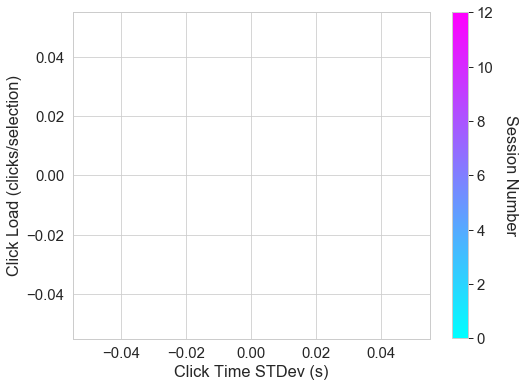

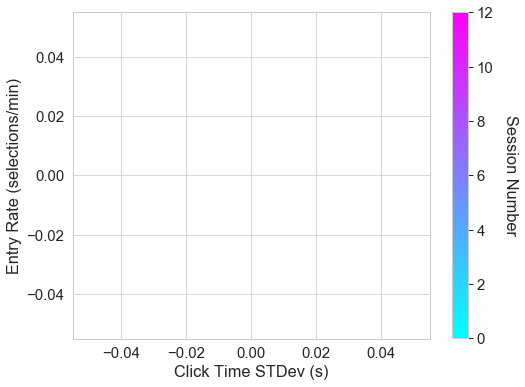

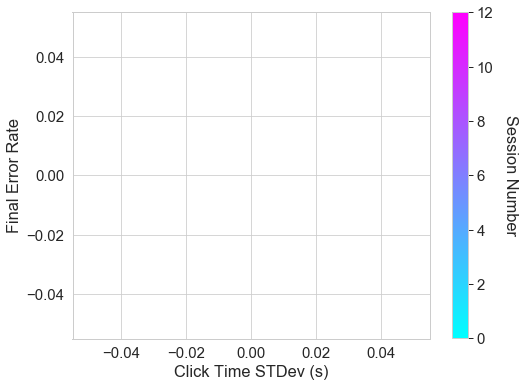

In [38]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(0,12), cmap=cmap)
sm.set_array([])

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.regplot(data=entry_df, x="Click Time STDev (s)", y="Click Load (clicks/selection)", scatter_kws={'facecolors':entry_df['color'], 'edgecolors':entry_df['color']})
cbar = plt.colorbar(sm)
cbar.set_label('Session Number', rotation=270,labelpad=25)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_click_var_vs_click_load.png", dpi=600)
plt.show()

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.regplot(data=entry_df, x="Click Time STDev (s)", y="Entry Rate (selections/min)", scatter_kws={'facecolors':entry_df['color'], 'edgecolors':entry_df['color']})
cbar = plt.colorbar(sm)
cbar.set_label('Session Number', rotation=270,labelpad=25)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_click_var_vs_entry_rate.png", dpi=600)

plt.show()

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.regplot(data=entry_df, x="Click Time STDev (s)", y="Final Error Rate", scatter_kws={'facecolors':entry_df['color'], 'edgecolors':entry_df['color']})
cbar = plt.colorbar(sm)
cbar.set_label('Session Number', rotation=270,labelpad=25)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_click_var_vs_error.png", dpi=600)

plt.show()

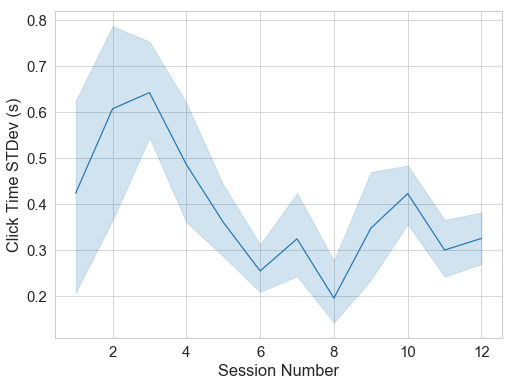

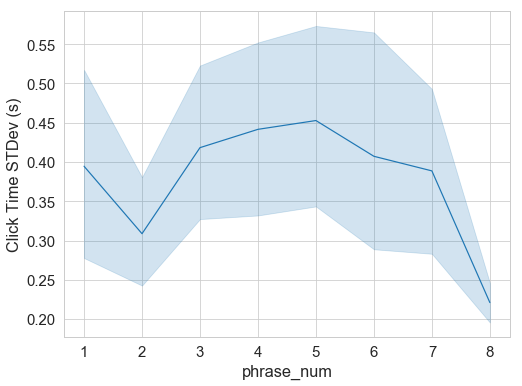

In [99]:
fig, axes = plt.subplots(1, figsize=(8, 6))
sns.lineplot(data=entry_df, y="Click Time STDev (s)", x="Session Number")
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_click_var_vs_session", dpi=600)
plt.show()

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.lineplot(data=entry_df, y="Click Time STDev (s)", x="phrase_num")
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_click_var_vs_phrase.png", dpi=600)

plt.show()

In [114]:
print_df = entry_df[(entry_df["Session Number"] >=5) & (entry_df["Session Number"] <20) & (entry_df["Keyboard"] == "RCS")]
entry_df_round = print_df.applymap(lambda x: round(x, min(int(2 - np.round(np.floor(np.log10(abs(x))))), 3)) if isinstance(x, float) and  np.isfinite(np.round(np.floor(np.log10(abs(x))))) else x)


# Nomon
# picture
# entry_df_round[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'Time Rotate', 'Entry Rate (selections/min)',
#        'Click Load (clicks/selection)', 'Correction Rate',  'Final Error Rate']].to_html()
# text
# entry_df_round[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'is_oov', 'Time Rotate', 'Entry Rate (wpm)',
#        'Click Load (clicks/char)', 'Correction Rate',  'Final Error Rate']].to_html()

# RCS
# picture
# entry_df_round[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'Scan Delay', 'Extra Delay', 'Entry Rate (selections/min)',
#        'Click Load (clicks/selection)', 'Correction Rate',  'Final Error Rate']].to_html()
# 
entry_df_round[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'is_oov', 'Scan Delay', 'Extra Delay', 'Entry Rate (wpm)',
       'Click Load (clicks/char)', 'Correction Rate',  'Final Error Rate']].to_html()




c:\users\nickb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Session Number</th>\n      <th>Phrase Number</th>\n      <th>Phrase Target</th>\n      <th>Final Typed</th>\n      <th>is_oov</th>\n      <th>Scan Delay</th>\n      <th>Extra Delay</th>\n      <th>Entry Rate (wpm)</th>\n      <th>Click Load (clicks/char)</th>\n      <th>Correction Rate</th>\n      <th>Final Error Rate</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>104</th>\n      <td>5</td>\n      <td>1</td>\n      <td>i love it out here</td>\n      <td>i love it out here. ._</td>\n      <td>IV</td>\n      <td>2.0</td>\n      <td>2.0</td>\n      <td>1.63</td>\n      <td>1.180</td>\n      <td>0.077</td>\n      <td>0.167</td>\n    </tr>\n    <tr>\n      <th>105</th>\n      <td>5</td>\n      <td>2</td>\n      <td>i8m coming to the show</td>\n      <td>i8m coming to the show</td>\n      <td>IV</td>\n      <td>2.0</td>\n      <td>2.0</td>\n      <td>2.90</td>\n     